### Clustering

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os

In [ ]:
# ensure scikit-learn’s runs single-threaded to reduce memory load.
os.environ["OMP_NUM_THREADS"] = "1"   # OpenMP threads
os.environ["MKL_NUM_THREADS"] = "1"   # MKL’s own thread pool

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.sparse import coo_matrix, csr_matrix

In [4]:
import json
import numpy as np
import joblib

In [ ]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

host = os.getenv("MY_SQL_HOST")
user = os.getenv("MY_SQL_USER")
password = os.getenv("MY_SQL_PASSWORD")
database = os.getenv("MY_SQL_DATABASE")

In [ ]:
import mysql.connector

def get_connection(host, user, password, database):
    mydb = mysql.connector.connect(
      host=host,
      user=user,
      password=password,
      database=database
    )
    return mydb

In [ ]:
connection = get_connection(host=host, user=user, password=password, database=database)
cursor = connection.cursor()
root_location = "E:\\applied data science capstone\\anime-recommendation\\modelling\\clustering\\exploration"

In [ ]:
query = """
SELECT
    user_id,
    anime_id,
    rating
FROM
    rating_v2
ORDER BY
    user_id;
"""
cursor.execute(query)
raw_data = cursor.fetchall()

In [ ]:
df = pd.DataFrame(raw_data, columns=["user_id", "anime_id", "rating"])
df["rating"] = pd.to_numeric(df["rating"])
# save data to file
filename = "E:\\applied data science capstone\\data\\etl\\extract\\transactions\\clustering_13_Jul.csv"
df.to_csv(filename, index=False)

In [7]:
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47161882 entries, 0 to 47161881
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 1.1 GB


In [ ]:
user_cat   = df['user_id'].astype('category')
anime_cat  = df['anime_id'].astype('category')
# re‑index users and anime
user_codes = user_cat.cat.codes
anime_codes = anime_cat.cat.codes
data = df['rating'].values

# build coo, then convert to csr
num_users  = user_codes.max() + 1
num_animes = anime_codes.max() + 1
user_item_sparse = coo_matrix((data, (user_codes, anime_codes)), shape=(num_users, num_animes)).tocsr()

id_to_user = dict(enumerate(user_cat.cat.categories))
id_to_anime = dict(enumerate(anime_cat.cat.categories))
anime_id_to_index = {v: k for k, v in id_to_anime.items()} 

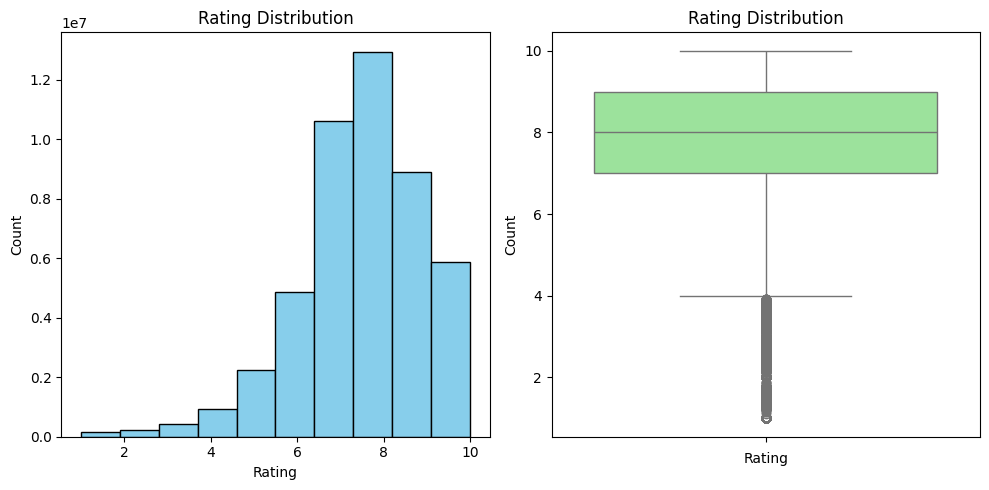

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df["rating"], color="lightgreen")
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\ratings.png")
plt.show()

In [ ]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    # print(f"at stage {k}")
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
    
    # print("did k means")
    cluster_labels = kmeans.fit_predict(user_item_sparse)

    # print("did cluster predictions means")
    # sil_score = silhouette_score(user_item_sparse, cluster_labels)

    # print("did silhouette scores")
    # silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

did k means
did k means
did k means
did k means
did k means
did k means
did k means
did k means
did k means
did k means
did k means


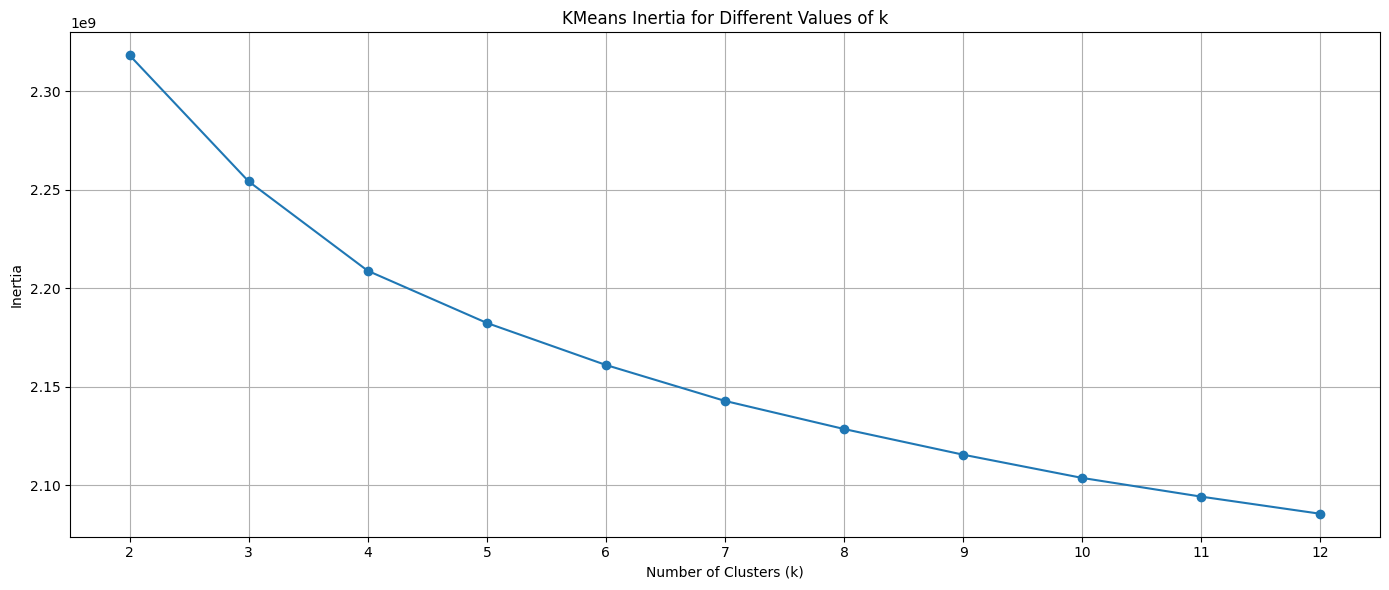

In [ ]:
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
# plt.title('Silhouette Scores for Different Values of k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(k_values)
# plt.grid(True)

plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\elbow_method_inertia.png")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_item_sparse)

# Assign cluster labels back to users
clusters_df = pd.DataFrame({
    'user_id' : [id_to_user[i] for i in range(len(user_clusters))],
    'cluster': user_clusters
})

df_with_cluster = df.merge(clusters_df, on="user_id")

In [ ]:
model_bundle = {
    'kmeans': kmeans,
    'df': df_with_cluster,
    'id_to_user': id_to_user,
    'id_to_anime': id_to_anime
}

# Store to file
joblib.dump(model_bundle, "E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

In [16]:
# Load everything
model_bundle = joblib.load("E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

kmeans = model_bundle['kmeans']
df_with_cluster = model_bundle["df"]

sample_indices = np.random.choice(user_item_sparse.shape[0], size=3000, replace=False)
sample_matrix = user_item_sparse[sample_indices]
sample_labels = user_clusters[sample_indices]

e:\organized-anime-recommendation\organized-anime-recommendation\.venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


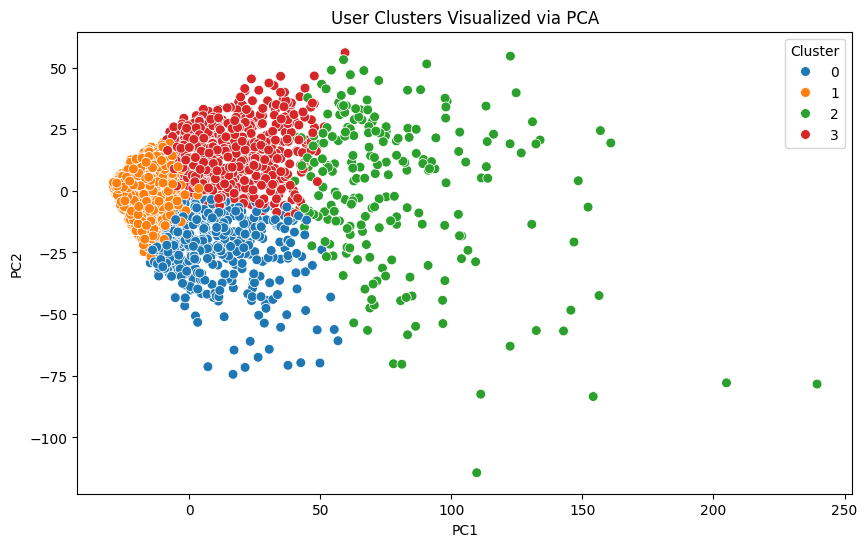

In [ ]:
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

# Step 4: Plot
df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{root_location}\\plots\\user_clusters.png")
plt.show()